In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import warnings
warnings.simplefilter('ignore')
import math
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, Febrary 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization (Continued)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.


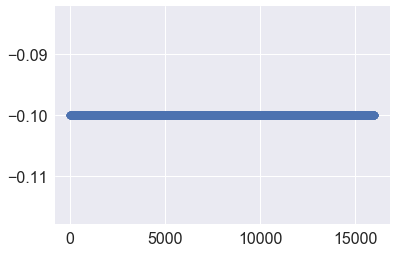

In [3]:
telecom_data = pd.read_csv('./HW3_data.csv', header=None)
telecom_data = np.array(telecom_data).T
X = telecom_data[:,0]
Y = telecom_data[:,1]
# check it has been read in correctly
a = Y**2 - X**2
plt.scatter(np.arange(a.shape[0]),a)

In [7]:
p = 0.000045
q = 0.000098
r = 0.003926

def exp_fn(X, Y, lmd1, lmd2):
    return r*X*np.exp((Y**2 - X**2)*(lmd1**2 + lmd2**2))

def f(X, Y, lmd1, lmd2):
    fs = p*(lmd2**2)*Y - q*(lmd1**2)*X + lmd1*exp_fn(X, Y, lmd1, lmd2)
    return np.sum(fs)

def fprime_lmd1(X, Y, lmd1, lmd2):
    fp = -2*q*lmd1*X + (1 + 2*(lmd1**2)*(Y**2 - X**2))*exp_fn(X, Y, lmd1, lmd2)
    return np.sum(fp)

def fprime_lmd2(X, Y, lmd1, lmd2):
    fp = 2*p*lmd2*Y + 2*lmd1*lmd2*(Y**2 - X**2)*exp_fn(X, Y, lmd1, lmd2)
    return np.sum(fp)

In [52]:
l1 = 2.05384
l2 = 0
m = Y.shape
# range of l1 and l2
lm1 = np.linspace(l1 - 15 , l1 + 15, 100)
lm2 = np.linspace(l2 - 15, l2 + 15, 100)

def plot_cost():
    # optimum values
    LM1, LM2 = np.meshgrid(lm1, lm2)

    l = np.array([f(X,Y, *(lmd))
                   for lmd in zip(np.ravel(LM1), np.ravel(LM2))])
    L = l.reshape(LM1.shape)

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(LM1, LM2, L, rstride=1, cstride=1, color='b', alpha=0.2)
    ax.contour(LM1, LM2, L, 20, color='b', alpha=0.5, offset=f(X, Y, l1, l2), stride=50)

    ax.set_xlabel('$\lambda1$')
    ax.set_ylabel('$\lambda2$')
    ax.set_zlabel('Total cost $L(x,y,\lambda1,\lambda2)$')
    ax.view_init(elev=30., azim=30)

    # plot the optimum 
    ax.plot([l1],[l2], f(X, Y, l1, l2) , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    return ax

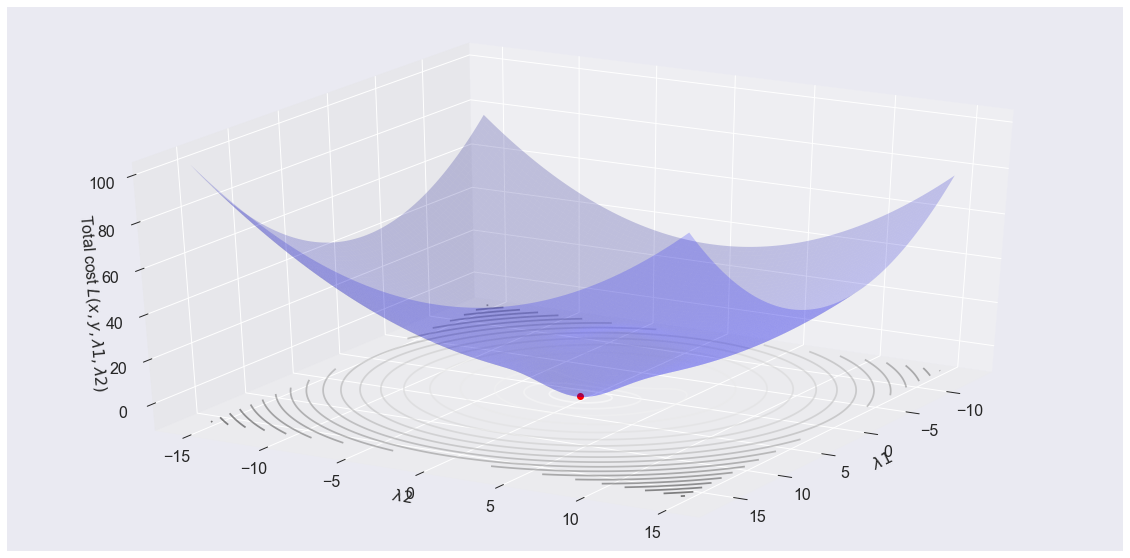

In [53]:
ax1 = plot_cost()

In [54]:
LM1, LM2 = np.meshgrid(lm1, lm2)
l = np.array([f(X,Y, *(lmd))
                   for lmd in zip(np.ravel(LM1), np.ravel(LM2))])
L = l.reshape(LM1.shape)

# Gradient Descent

In [56]:
def gradient_descent(X, Y, lmd_init, stopping_condition, step=0.001, maxsteps=0, precision = 0.001):
    
    costs = []
    m = Y.size # number of data points
    
    lmd = lmd_init
    
    history = [] # to store all thetas
    
    counter = 0
    oldcost = 0
    
    currentcost = f(X, Y, *(lmd))
    
    costs.append(currentcost)
    history.append(lmd)
    counter+=1
    
    update_times = []
    
#     while np.linalg.norm(np.array(*(lmd)) - np.array([2.05384, 0])) > precision:
    while stopping_condition(currentcost, oldcost, lmd, precision):
        start = time.time()
        oldcost=currentcost
        gradient = 1000*np.array([fprime_lmd1(X,Y,*(lmd)), fprime_lmd2(X,Y,*(lmd))])/m
        lmd = lmd - step*gradient # update
        
        end = time.time()
        update_times.append(end-start)
        
        
        history.append(lmd)
        currentcost = f(X, Y, *(lmd))
        costs.append(currentcost)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
    return history, costs, counter, lmd, update_times

# Stochastic gradient descent

In [57]:
# find the gradient one point at a time 

def sgd(X, Y, lmd_init, stopping_condition, step=0.001, maxsteps=0, precision=0.001, cost=False):
    m = Y.size 
    
    # shuffle data
    neworder = np.random.permutation(m)      
    X = X[neworder]
    Y = Y[neworder]
            
    # save history 
    history = [] 
    history_costs = []
    update_times = []
    
    # initialise params
    oldlmd = 0
    lmd = lmd_init
    counter = 0
    epoch = 0 
    
    # update history 
    history.append(lmd)
    
    # index of data point
    i = 0 

    # save the costs 
    if cost:
        currentcost = f(X[i],Y[i], *(lmd))
        counter+=1
        costsum = currentcost
        history_costs.append(costsum/counter)
    
    # iterate through all data points 
    while stopping_condition(lmd, precision):
        
        start = time.time()
        
        # update gradient    
        # scale the gradient by 1000 in order to get faster convergence
        gradient = 1000*np.array([fprime_lmd1(X[i],Y[i],*(lmd)), fprime_lmd2(X[i],Y[i],*(lmd))])
        oldlmd = lmd
        # update lambda
        lmd = lmd - step * gradient
        
        end = time.time()
        
        update_times.append(end-start)
        
        # increment observation index
        i += 1
        
        # reached one past the end of the data 
        if i == m:
            #break
            epoch +=1
            
            # shuffle the data
            neworder = np.random.permutation(m)
            X = X[neworder]
            Y = Y[neworder]
            
            # reset index to 0 
            i = 0
     
        # save the costs 
        if cost:
            currentcost = f(X[i],Y[i], *(lmd))
            costsum += currentcost
            history_costs.append(costsum/counter)
        
        counter +=1
        history.append(lmd)
        
        if maxsteps:
            if counter == maxsteps:
                break
                
                
    return history, counter, epoch, history_costs, lmd, update_times

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$
Based on your analysis of the loss function $L$, explain what is happening to your descent algorithms.

In [58]:
def stopping_condition_precision_gd(currentcost, oldcost, lmd, precision):
    return np.linalg.norm(np.array([lmd[0], lmd[1]]) - np.array([2.05384, 0])) > 1e-3
def stopping_condition_precision_sgd(lmd, precision):
    return np.linalg.norm(np.array([lmd[0], lmd[1]]) - np.array([2.05384, 0])) > 1e-3

(-2.47865, 0)
(-3, 0)
(-5, 0)
(-10, 0)


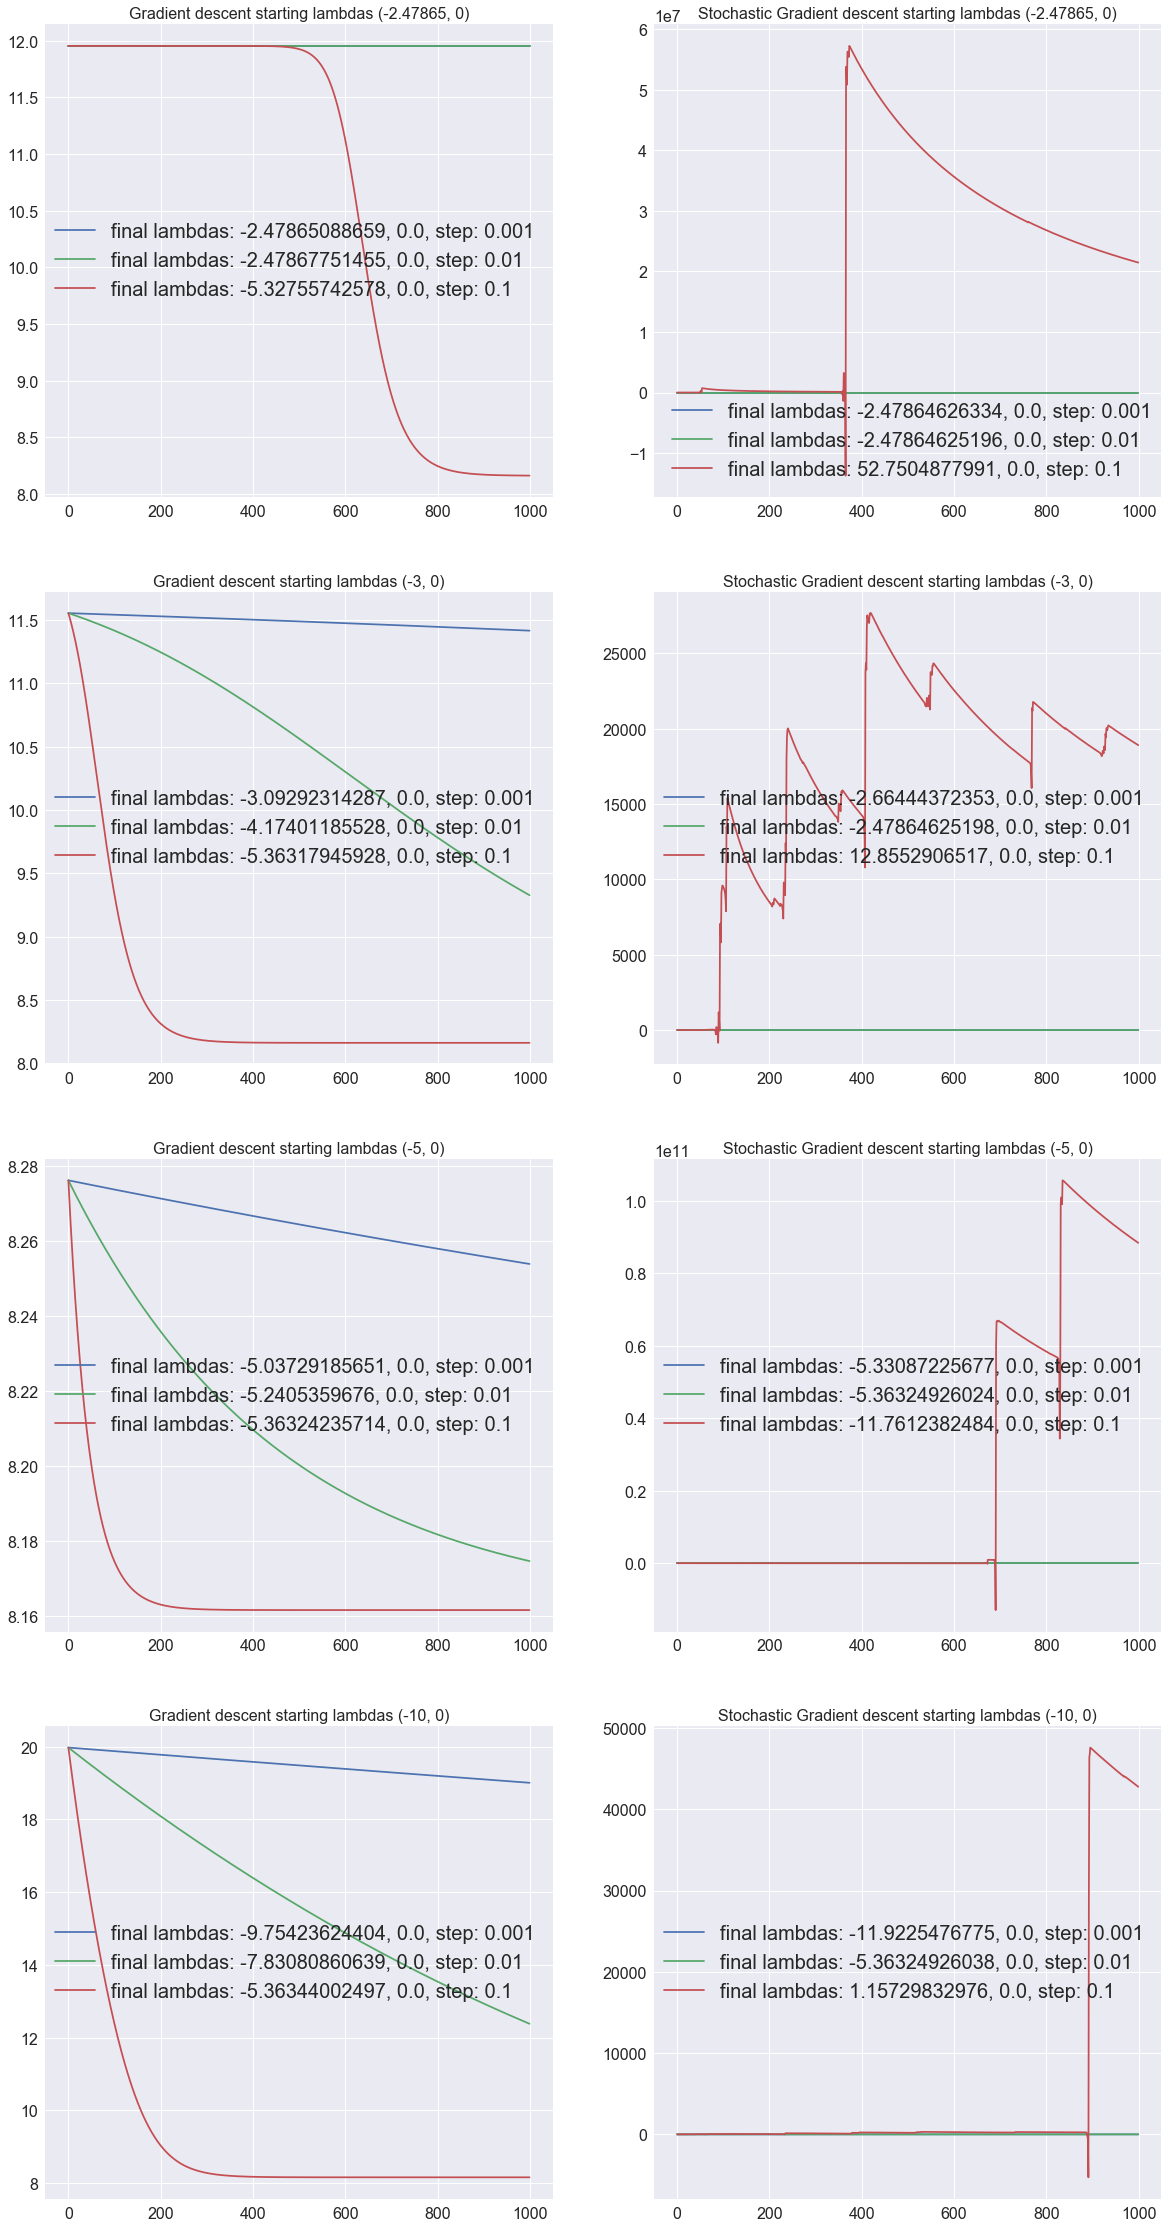

In [59]:
steps = [0.001, 0.01, 0.1]
lambdas = [(-2.47865,0), (-3,0), (-5,0), (-10,0)]
i=1
plt.figure(figsize=(20, 40))
for lmd in lambdas:
    print(lmd)
    plt.subplot('42'+str(i))
    for step in steps:
        history, costs, counter, lmd_gd, update_times = gradient_descent(X, Y, 
                                                                         lmd, 
                                                                         stopping_condition=stopping_condition_precision_gd, 
                                                                         step=step, 
                                                                         maxsteps=1000)
        plt.plot(range(len(costs)), costs, label='final lambdas: '+str(lmd_gd[0]) + ", " + str(lmd_gd[1]) + ', step: ' + str(step))
    plt.title('Gradient descent starting lambdas ' + str(lmd))
    plt.legend(loc="best", fontsize=20)
    i+=1
    plt.subplot('42'+str(i))
    for step in steps:
        history_sgd, counter_sgd, epoch_sgd, history_costs_sgd, lmd_sgd, update_times_sgd = sgd(X, Y, 
                                                                                lmd, 
                                                                                stopping_condition=stopping_condition_precision_sgd, 
                                                                                step=step, 
                                                                                maxsteps=1000, 
                                                                                cost=True)
        plt.plot(range(len(history_costs_sgd)), history_costs_sgd, label='final lambdas: '+str(lmd_sgd[0]) + ", " + str(lmd_sgd[1]) + ', step: ' + str(step))
    plt.title('Stochastic Gradient descent starting lambdas ' + str(lmd))
    plt.legend(loc="best", fontsize=20)
    i+=1

In [60]:
print('local min', f(X,Y, -5.36, 0)) # average loss
print('global min', f(X,Y, l1, l2)) # average loss

local min 8.16153783357
global min -9.93410402505


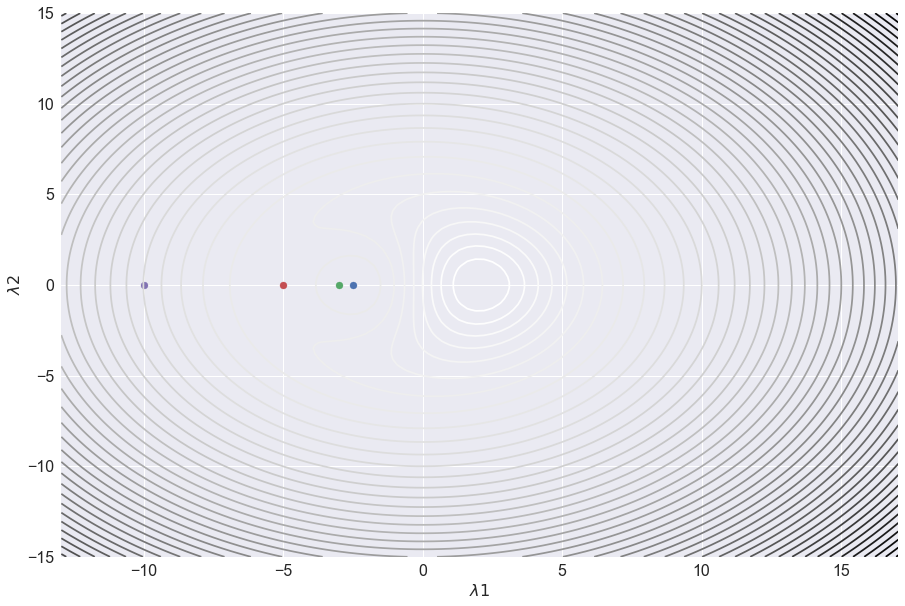

In [67]:
plt.figure(figsize=(15,10))
plt.contour(LM1, LM2, L, 50, color='b')
# plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('$\lambda1$')
plt.ylabel('$\lambda2$')
plt.scatter(-2.47865,0)
plt.scatter(-3,0)
plt.scatter(-5,0)
plt.scatter(-10,0)

In [82]:
lm1 = np.linspace(-12 , 0, 100)
lm2 = np.zeros((len(lm1),0))
l = [f(X,Y, lmd, 0) for lmd in lm1]

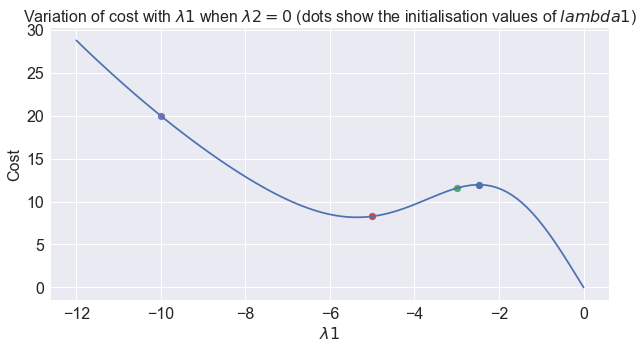

In [89]:
plt.figure(figsize=(10,5))
plt.plot(lm1, l)
plt.xlabel('$\lambda1$')
plt.ylabel('Cost')
plt.title('Variation of cost with $\lambda1$ when $\lambda2 = 0$ (dots show the initialisation values of $lambda1$)')
plt.scatter(-2.47865,f(X,Y, -2.47865,0))
plt.scatter(-3,f(X,Y, -3,0))
plt.scatter(-5,f(X,Y, -5,0))
plt.scatter(-10,f(X,Y, -10,0))

All the initialisations of gradient descent are getting stuck in the local minimum of the cost which occurs at $\lambda1 = -5.36$ and $\lambda2 = 0$. With stochastic gradient descent, the cost fluctuates unpredictably and the final values of lambda} are all different. 

### Part B: Simulated Annealing
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

**Extra Credit**
For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

In [90]:
# proposal distribution
mean = (0, 0)
cov = [[1, 0], [0, 1]]
proposalf = lambda l1, l2: np.random.multivariate_normal((l1, l2), [[1, 0], [0, 1]], 1)[0]

#temperature function
tf = lambda t: 0.8*t 

itf = lambda length: math.ceil(1.2*length) #iteration function

In [91]:
proposalf(*(-5,0))

array([-5.46209462,  0.29874728])

## Simulated Annealing

In [92]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    
    accumulator=[]
    
    # initial values of lambda 1 and lambda 2
    best_solution = old_solution = initials['solution']
    
    # starting temperature
    T=initials['T']
    
    # the number of iterations at the starting temperature
    length=initials['length']
    
    best_energy = old_energy = energyfunc(X, Y, *old_solution)
    accepted=0
    total=0
    
    # total number of epochs
    for index in range(epochs):
        print("Epoch", index)
        
        if index > 0:
            # decrease the temperature according to a cooling schedule
            T = tempfunc(T)
            # the number of iterations increases as the temperature decreases 
            length=iterfunc(length)
            
        print("Temperature", T, "Length", length)
        
        # carry out the number of iterations for the current temp
        for it in range(length):
            
            total+=1
            
            # new values of l1 and l2
            new_solution = proposalfunc(*old_solution)
            
            # new value of the loss func 
            new_energy = energyfunc(X, Y, *new_solution)
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            
            # check whether loss is less than previous loss or a uniform random number is less than exp(-delta/T)
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
               
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator


In [93]:
# initialisation temperature, number of iterations at each temperature
lmd_init = [-5, 0]
inits=dict(solution=lmd_init, length=100, T=10)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, proposalf)

Epoch 0
Temperature 10 Length 100
Epoch 1
Temperature 8.0 Length 120
Epoch 2
Temperature 6.4 Length 144
Epoch 3
Temperature 5.120000000000001 Length 173
Epoch 4
Temperature 4.096000000000001 Length 208
Epoch 5
Temperature 3.276800000000001 Length 250
Epoch 6
Temperature 2.621440000000001 Length 300
Epoch 7
Temperature 2.097152000000001 Length 360
Epoch 8
Temperature 1.6777216000000008 Length 432
Epoch 9
Temperature 1.3421772800000007 Length 519
Epoch 10
Temperature 1.0737418240000005 Length 623
Epoch 11
Temperature 0.8589934592000005 Length 748
Epoch 12
Temperature 0.6871947673600004 Length 898
Epoch 13
Temperature 0.5497558138880003 Length 1078
Epoch 14
Temperature 0.4398046511104003 Length 1294
Epoch 15
Temperature 0.3518437208883203 Length 1553
Epoch 16
Temperature 0.28147497671065624 Length 1864
Epoch 17
Temperature 0.22517998136852502 Length 2237
Epoch 18
Temperature 0.18014398509482002 Length 2685
Epoch 19
Temperature 0.14411518807585602 Length 3222
Epoch 20
Temperature 0.1152921

In [99]:
print('best solution', bs)
print('best energy', be)

best solution [  2.05100308e+00   1.30893242e-03]
best energy -9.93408139365


In [101]:
print('proximity to optimal solution ', np.linalg.norm(bs - np.array([2.05384, 0])))

proximity to optimal solution  0.00312432352512


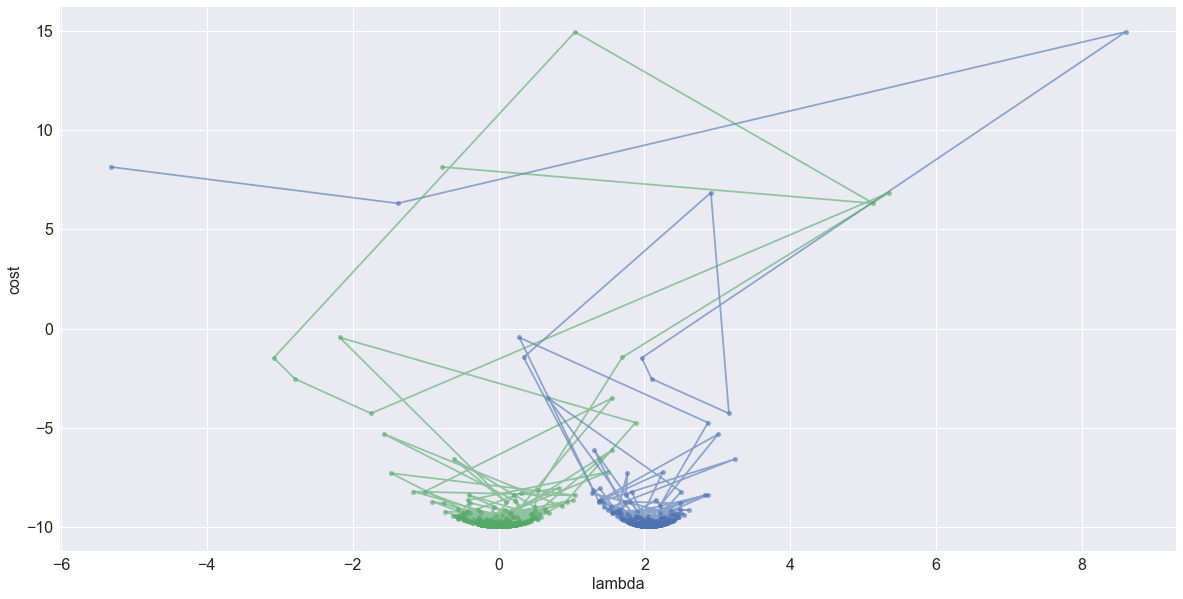

In [103]:
plt.figure(figsize=(20,10))
xs = np.linspace(-10.,10.,1000)
# plt.plot(xs, f(X,Y, xs), lw=2);
eout=list(enumerate(out))
#len([e[1] for i,e in eout if i%100==0]), len([e[2] for i,e in eout if i%100==0])
plt.plot([e[1] for i,e in eout if i%100==0], [e[2] for i,e in eout if i%100==0], 'o-', alpha=0.6, markersize=5)
plt.xlabel('lambda')
plt.ylabel('cost')
#plt.plot([e[1] for e in out], [f(e[1]) for e in out], '.', alpha=0.005)
# plt.xlim([-3,10])
# plt.ylim([-10,100])

This plot shows the movement in the lambda 1 and lambda 2 parameters during the course of the simulated annealing algorithm. Initially there appears to be large fluctuation in the parameters, but as the temperature is reduced, the values of lambda begin to converge around the optimum values. 

The evolution of the lambda values can also be plot as a function of the iteration to better observe the reduction in oscillation magnitude. 

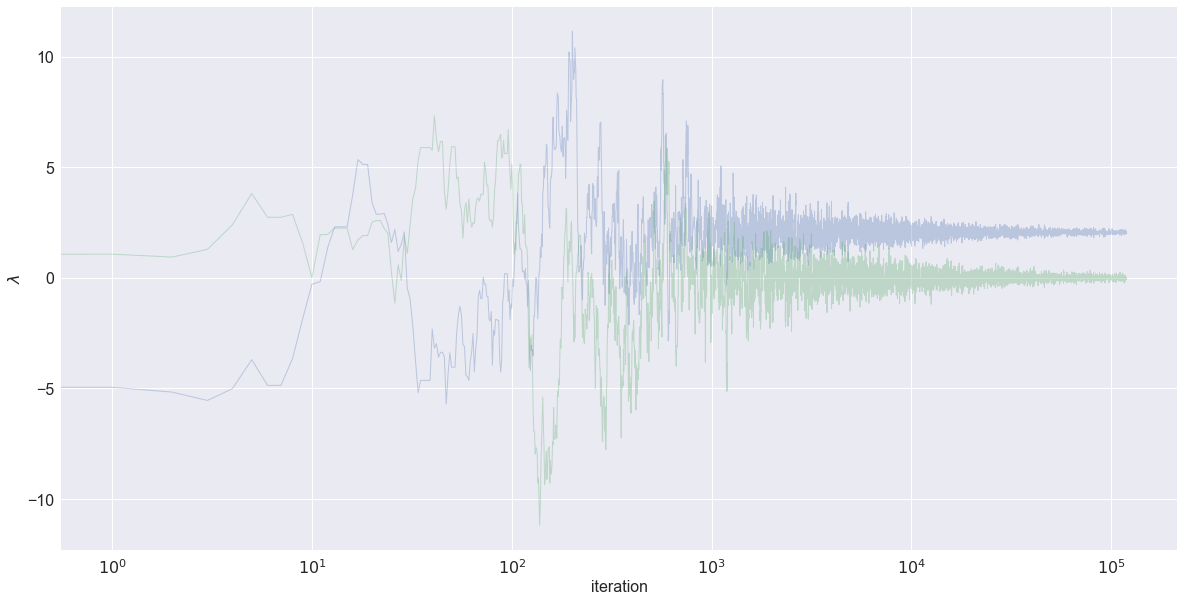

In [105]:
plt.figure(figsize=(20,10))
plt.plot([e[1] for e in out], alpha=0.3, lw=1);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('$\lambda$')

The fluctuation in cost as a function of iteration can also be visualised. This plot shows that initially there are large fluctuations in cost, but as the number of iterations increases, the magnitude of the oscillations decreases. 

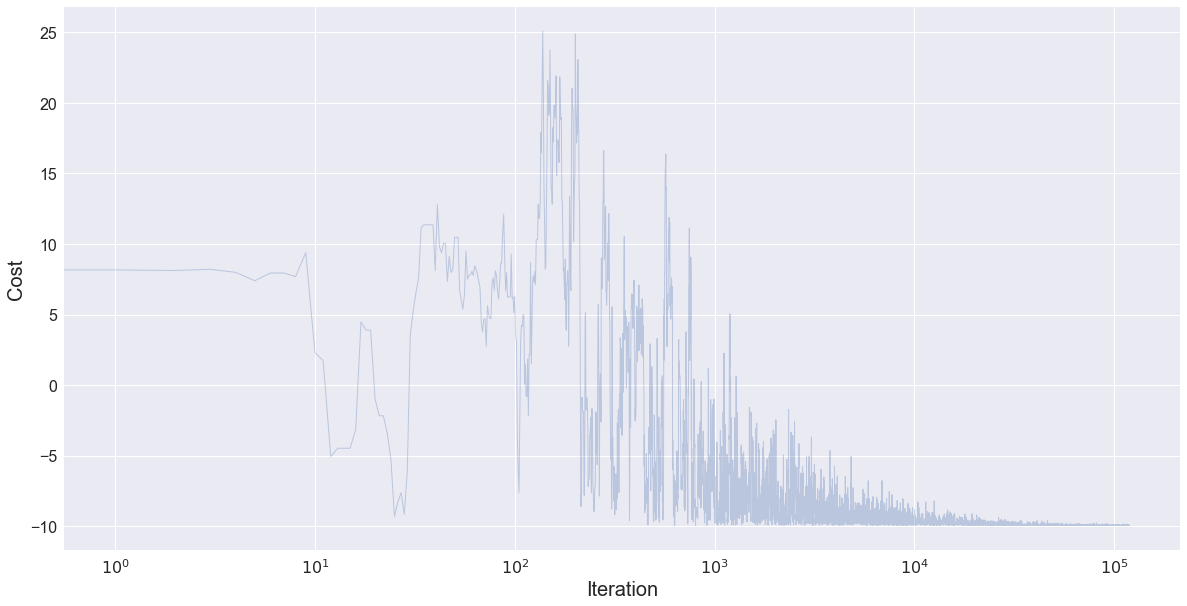

In [107]:
plt.figure(figsize=(20,10))
plt.plot(range(len(out)),[e[2] for e in out], alpha=0.3, lw=1);
plt.xscale('log', fontsize=20)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Cost', fontsize=20)

Simulated annealing produces either a set of homogeneous markov chains, one at each temperature or a single inhomogeneous markov chain. 


As the number of iterations increases, the markov chain converges to the stationary distribution and the values stabilize. 